In [2]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.join(Path.home(), 'QUIC-Projects'))
sys.path

['/home/quic/QUIC-Projects/summary_ipynb',
 '/home/quic/.vscode/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles',
 '/home/quic/.vscode/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles/lib/python',
 '/home/quic/anaconda3/envs/quic/lib/python38.zip',
 '/home/quic/anaconda3/envs/quic/lib/python3.8',
 '/home/quic/anaconda3/envs/quic/lib/python3.8/lib-dynload',
 '',
 '/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages',
 '/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages/IPython/extensions',
 '/home/quic/.ipython',
 '/home/quic/QUIC-Projects',
 '/home/quic/QUIC-Projects']

In [7]:
import time
import os
expname = time.strftime('%c',time.localtime(time.time()))
exp_path = os.path.join(os.getcwd(), expname)
os.mkdir(exp_path)

In [8]:
from custom_qiskit_v3_1.datageneration import Sklearn_DataLoader
from sklearn.datasets import load_iris
dl = Sklearn_DataLoader('iris', labels=(0,1))
X, y, Xt, yt = dl(2**6, 0)


0.6111111111111112

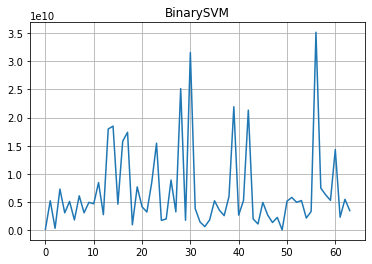

In [9]:
from custom_qiskit_v3_1.classifier import BinarySVM, Kernel
from custom_qiskit_v3_1.datageneration import Sklearn_DataLoader

dl = Sklearn_DataLoader('iris', labels=(0,1), normalize=2, mean=0)
X, y, Xt, yt = dl(2**6, 0)
svm = BinarySVM(Kernel('Pow2', gamma=1), C=None)
svm.fit(X, y, 'REDUCED_SVM')
svm.plot('alpha')
svm.accuracy(Xt, yt)

0.4722222222222222

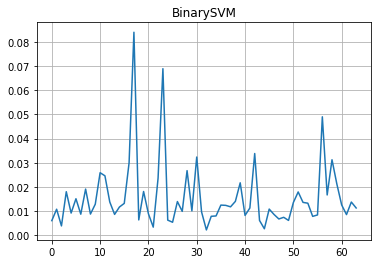

In [10]:
svm = BinarySVM(Kernel('Pow2', gamma=1), C=1)
svm.fit(X, y, 'REDUCED_QASVM')
svm.plot('alpha')
svm.accuracy(Xt, yt)

In [11]:
from itertools import starmap, repeat

def random_acc(C, dl, kernel):
    X, y, Xt, yt = dl(2**3, 0)
    svm = BinarySVM(kernel=kernel, C=C)
    svm.fit(X, y, 'QASVM')
    return 1-svm.accuracy(Xt, yt)

def mean_function(func, times, *args, **kwargs):
    lst = [func(*args, **kwargs) for _ in range(times)]
    return np.mean(lst), np.std(lst)

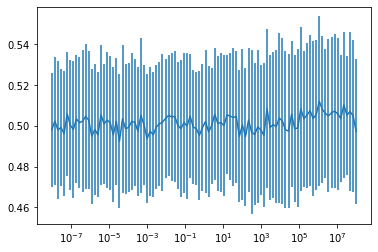

In [12]:
from tqdm.notebook import tqdm
import numpy as np 
from matplotlib import pyplot as plt 

dl = Sklearn_DataLoader('iris', labels=(0,1), mean=0)
kernel = Kernel('Pow2', 1)

result = np.array([mean_function(random_acc, 100, C, dl, kernel) for C in tqdm(np.logspace(-8, 8, 100))])

plt.errorbar(np.logspace(-8, 8, 100), result[:,0], yerr=result[:,1])
plt.xscale('log')


In [30]:
import multiprocessing as mp 
import numpy as np
import matplotlib.pyplot as plt
from custom_qiskit_v3_1.classifier import Kernel, BinarySVM
from tqdm.notebook import tqdm
from custom_qiskit_v3_1.datageneration import Sklearn_DataLoader
from sklearn.svm import SVC

def f(C):
    dl = Sklearn_DataLoader('iris', labels=(0,1), mean=0)
    X, y, Xt, yt = dl(2**6, 0)

    kernel = Kernel('Pow2')
    svm1 = BinarySVM(kernel, C=C)
    svm2 = BinarySVM(kernel, C=C)
    svm3 = BinarySVM(kernel, C=C)
    svm4 = BinarySVM(kernel, C=C)
    svm1.fit(X, y, 'SVM')
    svm2.fit(X, y, 'QASVM')
    svm3.fit(X, y, 'REDUCED_SVM')
    svm4.fit(X, y, 'REDUCED_QASVM')
    return [C, svm1.accuracy(Xt, yt), svm2.accuracy(Xt, yt), svm3.accuracy(Xt, yt), svm4.accuracy(Xt, yt)]

Cs = np.array([np.logspace(-8, 8, 100) for _ in range(100)]).reshape(-1)
if __name__=='__main__':
    res = [f(C) for C in tqdm(Cs)]
res = sorted(res, key=lambda x:x[0])

a = np.array(np.array_split(res, 100))
err_mean = 1-a.mean(axis=1)[:, 1:5]
err_std = a.std(axis=1)[:, 1:5]
C = a.mean(axis=1)[:,0]

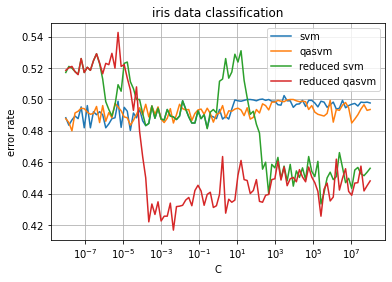

<Figure size 432x288 with 0 Axes>

In [31]:
import matplotlib.pyplot as plt
import time
plt.errorbar(C[:], err_mean[:, 0], label='svm')
plt.errorbar(C[:], err_mean[:, 1], label='qasvm')
plt.errorbar(C[:], err_mean[:, 2], label='reduced svm')
plt.errorbar(C[:], err_mean[:, 3], label='reduced qasvm')
plt.xscale('log')

plt.grid()
plt.legend()
plt.xlabel('C')
plt.ylabel('error rate')
plt.title('iris data classification')
plt.show()
plt.gcf().savefig(os.path.join(exp_path,'fig.png'))